<h3>Dependencies

In [147]:
import sys, os

import numpy as np
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r

from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

<h3> Models

In [126]:
# SDOF free vibration
def sdof_free_vibr(x, t):
    return [x[1], -0.1 * x[1] - x[0]]

# SDOF harmonic excitation
def sdof_harmonic(x, t, forcing_freq=1.2):
    return [x[1], -0.1 * x[1] - x[0] + np.cos(forcing_freq * t)]

# SDOF harmonic excitation with friction
def sdof_friction(x, t, friction_force_ratio=0.5, forcing_freq=1.2):
    return [
        x[1],
        -0.1 * x[1]
        - x[0]
        - friction_force_ratio * np.sign(x[1])
        + np.cos(forcing_freq * t),
    ]

<h3> Coefficients dictionary

In [127]:
class coeffs_dictionary(T.nn.Module):
    def __init__(self, n_combinations):

        super(coeffs_dictionary, self).__init__()
        self.linear = T.nn.Linear(n_combinations, 1, bias=False)
        # Setting the weights to zeros
        self.linear.weight = T.nn.Parameter(0 * self.linear.weight.clone().detach())
    
    def forward(self, x):
        
        return self.linear(x)

<h4> Feature Functions

In [188]:
def generic_force_features(x, t, phases, torchFlag=True):
    if torchFlag:
        return T.column_stack(
            (
                *[T.cos(ph * t) for ph in phases], # trigonometric features
                # *[T.sign(x[:, k]) for k in (0, 1)], # signum features
                *[T.ones(size=(x.shape[0],)), x[:, 0], x[:, 1],  
                         x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2, 
                         x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,]# polynomial features
            )
        )
    else:
        return np.column_stack(
            (
                *[np.cos(ph * t) for ph in phases],                
                # *[np.sign(x[:, k]) for k in (0, 1)], 
                *[np.ones(shape=(x.shape[0],)), x[:, 0], x[:, 1],  
                          x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2,
                          x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,]
            )
        )

<h4> Sparse ID function

In [189]:
## Generic RK-SINDy model
def rk4th_SparseId_forcing(x, LibsCoeffs, times, timesteps, Params, paramSize, phases):

    d1 = generic_force_features(x, times, phases)
    k1 = T.column_stack((x[:, 1].unsqueeze(1), (- 2 * Params.zeta * Params.omega * x[:, 1] - Params.omega ** 2 * x[:, 0]).unsqueeze(1) + T.cos(Params.forcing_freq * times) + LibsCoeffs(d1)))
    
    xtemp = x + 0.5 * timesteps * k1
    d2 = generic_force_features(xtemp, times + 0.5 * timesteps, phases)
    k2 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * Params.zeta * Params.omega * xtemp[:, 1] - Params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(Params.forcing_freq * (times + 0.5 * timesteps)) + LibsCoeffs(d2)))

    xtemp = x + 0.5 * timesteps * k2
    d3 = generic_force_features(xtemp, times + 0.5 * timesteps, phases)
    k3 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * Params.zeta * Params.omega * xtemp[:, 1] - Params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(Params.forcing_freq * (times + 0.5 * timesteps)) + LibsCoeffs(d3)))

    xtemp = x + timesteps * k3
    d4 = generic_force_features(xtemp, times + timesteps, phases)
    k4 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * Params.zeta * Params.omega * xtemp[:, 1] - Params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(Params.forcing_freq * (times + 0.5 * timesteps)) + LibsCoeffs(d4)))

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

<h4> Learning function

In [190]:
def learning_sparse_model(Coeffs, train_set, times, Params, paramSize, phases=(1.1, 1.2, 1.3), lr_reduction=10):

    # Define optimizer
    opt_func = optim_all.RAdam(
        Coeffs.parameters(), lr=Params.lr, weight_decay=Params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((Params.num_iter, Params.num_epochs))
    #########################
    ###### Training #########
    #########################
    for p in range(Params.num_iter):
        for g in range(Params.num_epochs):
            Coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()
            y_total = train_set

            ##################################
            # One forward step predictions
            ##################################

            y_pred = rk4th_SparseId_forcing(y_total[:-1], Coeffs, times[:-1], timesteps=timesteps_i, Params=Params, paramSize=paramSize, phases=phases)

            ##################################
            # One backward step predictions
            ##################################
            y_pred_back = rk4th_SparseId_forcing(y_total[1:], Coeffs, times[1:], timesteps=-timesteps_i, Params=Params, paramSize=paramSize, phases=phases)

            loss_new += criteria(y_pred, y_total[1:]) + weights[0] * criteria(
                y_pred_back, y_total[:-1]
            )

            # loss_new /= y[0].shape[0]
            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write("\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]" % (p + 1, Params.num_iter, g + 1, Params.num_epochs, loss_track[p, g], opt_func.param_groups[0]["lr"],))

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = Coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > Params.tol_coeffs).type(T.float)
        Coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        Coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(Coeffs.parameters(), lr=new_lr, weight_decay=Params.weightdecay)

    return Coeffs, loss_track

<h4>Random seed

In [191]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

<h3>Parameters

In [200]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    # save_model_path: str = "./Results/SDOF_free_vibration/"
    save_model_path: str = "./Results/Refactored/"
    weightdecay: float = 0.0
    timefinal: float = 50.0
    timestep: float = 5e-3
    normalize: bool = False
    tol_coeffs: float = 5e-2
    noise_level: float = 1e-1
    noisy_input_flag: bool = True
    omega: float = 1.0
    zeta: float = 0.05
    omega_noise: float = 1e-1
    zeta_noise: float = 2e-1
    model: str = "friction" # "free", "forced", "friction"
    forcing_freq: float = 1.2
    friction_ratio: float = 0.5
    
Params = parameters()

if Params.noisy_input_flag:
    Params.omega = np.random.normal(loc=Params.omega, scale=Params.omega_noise)
    Params.zeta = np.random.normal(loc=Params.zeta, scale=Params.zeta_noise)

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

<h3> Generate noisy measurements - Training Data

In [201]:
ts = np.arange(0, Params.timefinal, Params.timestep)

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
sol = solve_ivp(lambda t, x: sdof_friction(x, t, friction_force_ratio=Params.friction_ratio, forcing_freq=Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)

x = np.transpose(sol.y)

# Generate noisy measurements
x = np.random.normal(loc=x, scale=Params.noise_level * np.abs(x), size=x.shape)

In [202]:
# Define dataloaders
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

phases = np.arange(1., 2.01, 0.1)
no_of_terms = generic_force_features(train_dset[:2], times[:2], phases=phases).shape[1]

Coeffs = coeffs_dictionary(no_of_terms)

# # Learning Coefficients
Coeffs, loss_track = learning_sparse_model(Coeffs, train_dset, times, Params, paramSize=no_of_terms, phases=phases)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

Learned_Coeffs

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 3.41e-02] [Learning rate: 1.00e-04]

array([[ 0.        ],
       [-0.        ],
       [-0.4320899 ],
       [-0.09165165],
       [-0.07340564],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.64390665],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.        ],
       [ 0.251901  ],
       [-0.2165294 ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [203]:
no_of_terms

21

<h3>Generate data to be plotted (for refined time intervals) 

In [204]:
# ts_refine = np.arange(0, Params.timefinal, 1e-2)
ts_refine = ts

learnt_deri = lambda t, z: (np.array([z[1], 
                                      - 2 * Params.zeta * Params.omega * z[1] 
                                      - Params.omega ** 2 * z[0] 
                                      + generic_force_features(np.expand_dims(z, axis=0), t, phases=phases, torchFlag=False) @ Learned_Coeffs 
                                      + np.cos(Params.forcing_freq * t)]))

sol = solve_ivp(lambda t, x: sdof_friction(x, t, Params.friction_ratio, Params.forcing_freq), t_span=[ts_refine[0], ts_refine[-1]], y0=x0, t_eval=ts_refine)

x_refine = np.transpose(sol.y)

sol_learnt = solve_ivp(learnt_deri, [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine,)
x_learnt = np.transpose(sol_learnt.y)

C:\Users\cllathourakis\AppData\Local\Temp\ipykernel_11472\2349536393.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  learnt_deri = lambda t, z: (np.array([z[1],


<h3>Plotting

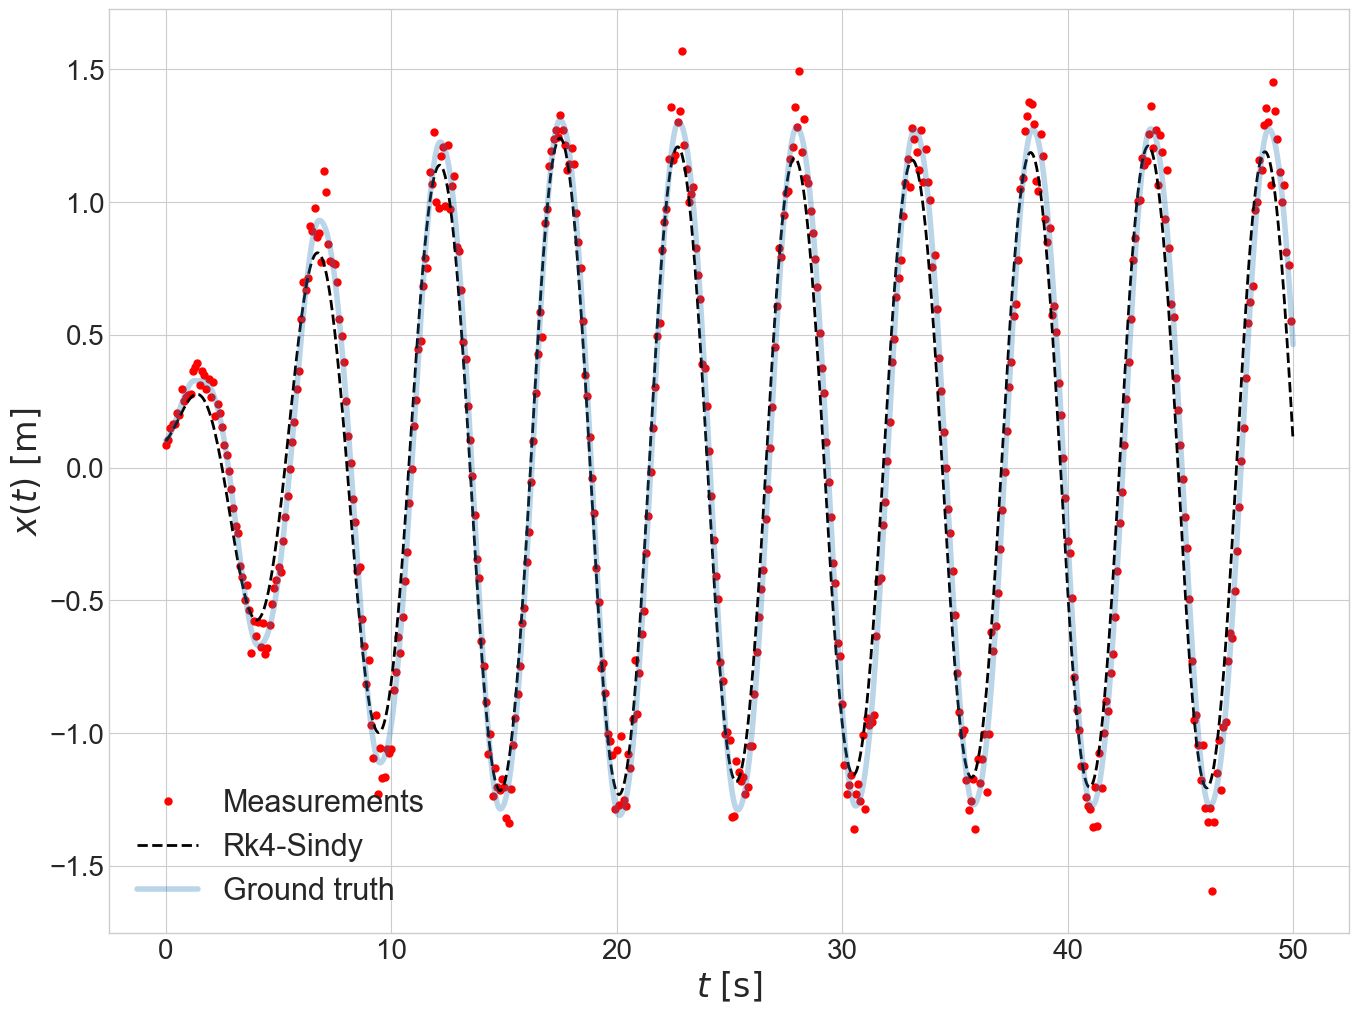

In [205]:
plt.figure(figsize=(16,12))

plt.plot(ts[::20], x[::20, 0], "ro", markersize=5, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 0], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 0], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1., 0.6))#, loc='upper right')
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$x(t) \, \, \mathrm{[m]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

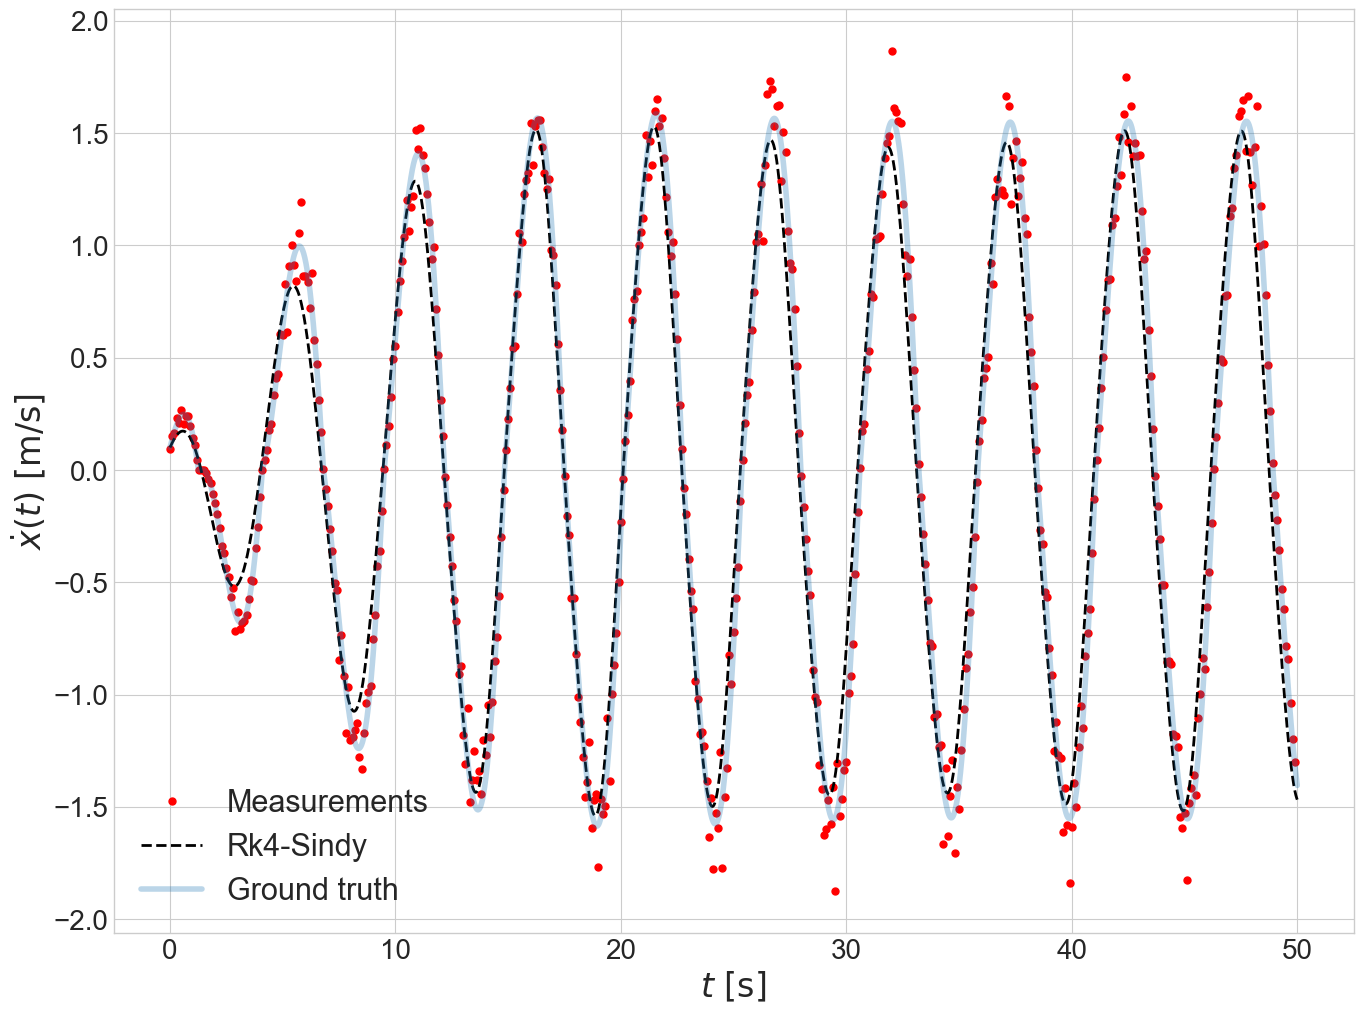

In [206]:
plt.figure(figsize=(16,12))

plt.plot(ts[::20], x[::20, 1], "ro", markersize=5, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 1], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 1], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$\dot{x}(t) \, \, \mathrm{[m/s]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

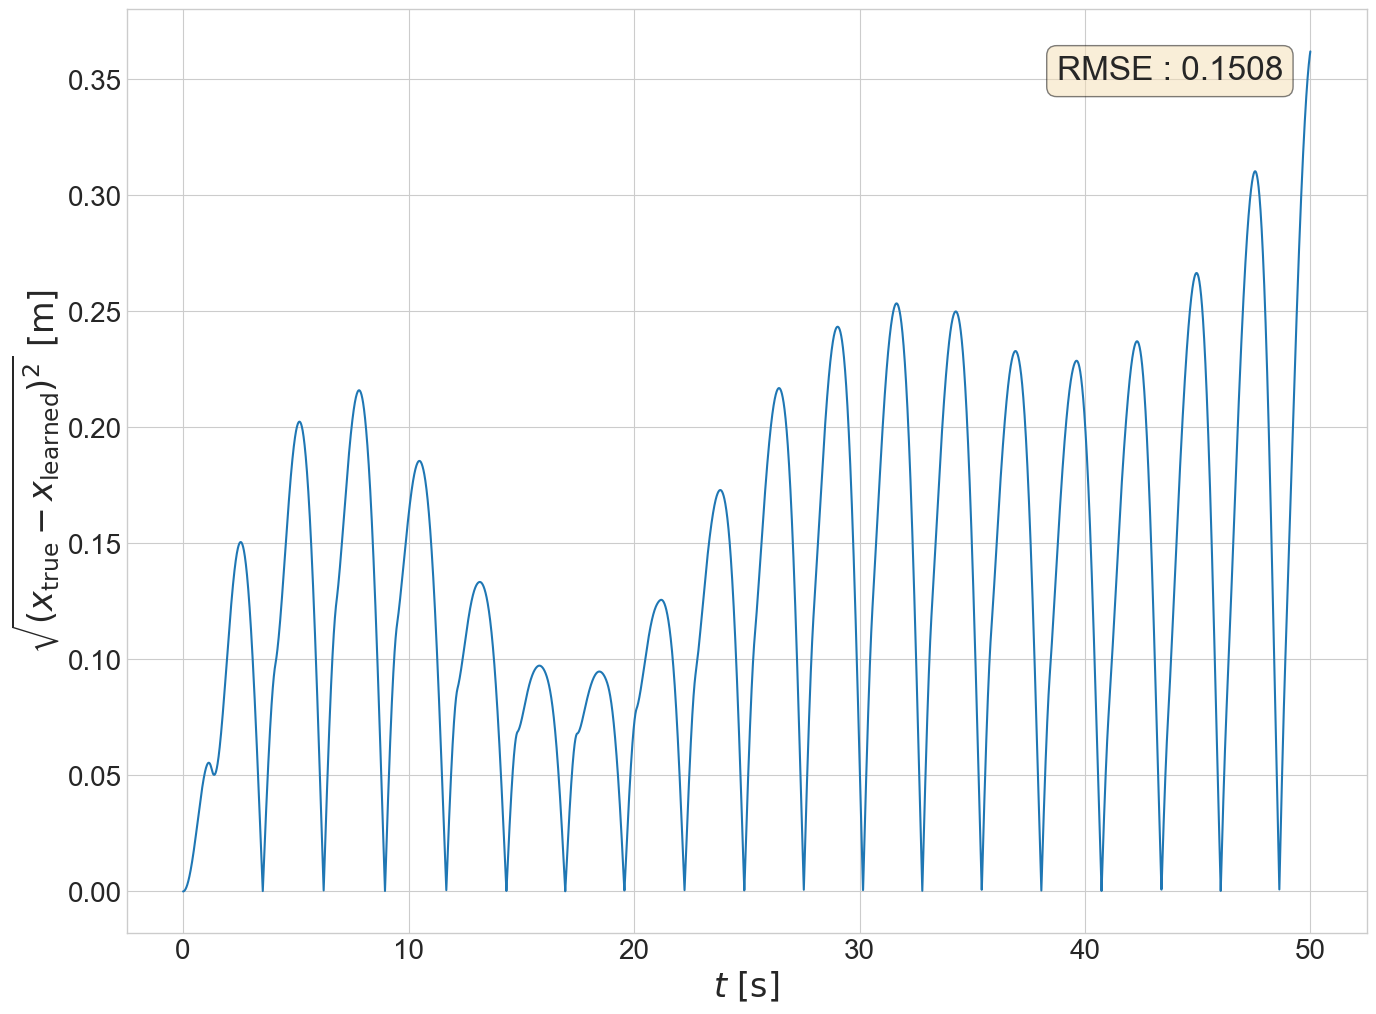

In [207]:
ind = 0

# relError = np.abs((x_refine[:, ind] - x_learnt[:, ind]) / x_refine[:, ind])
squaredError = np.sqrt((x_refine[:, ind] - x_learnt[:, ind]) ** 2)

fig, ax = plt.subplots(figsize=(16,12))

# plt.plot(ts_refine, relError, label='Relative Error')
ax.plot(ts_refine, squaredError, label="Squared Error")

rmse = np.sqrt(((x_refine[:, ind] - x_learnt[:, ind]) ** 2).sum() / x_learnt.shape[0])
textstr = f"RMSE : {rmse:.4f}"

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top', bbox=props)

# plt.yscale("log")

# plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))

ax.set_xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
# plt.ylabel(r"$\mid \frac{x_{\mathrm{true}} - x_{\mathrm{learned}}}{x_{\mathrm{true}}} \mid \, \, \mathrm{[-]}$", fontsize=24)
# plt.ylabel(r"$\mid \frac{\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}}{\dot{x}_{\mathrm{true}}} \mid \, \, \mathrm{[-]}$", fontsize=24)
# plt.ylabel(r"$\sqrt{(\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}) ^2} \, \, \mathrm{[m/s]}$", fontsize=24)
ax.set_ylabel(r"$\sqrt{(x_{\mathrm{true}} - x_{\mathrm{learned}}) ^2} \, \, \mathrm{[m]}$", fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=20)
# ax.xticks(fontsize=20)
# ax.yticks(fontsize=20)

plt.show()


0.12267750845240324

In [27]:
np.sqrt((((x_refine[:, ind] - x_learnt[:, ind])**2).sum()/x_learnt.shape[0]))

0.12267750845240324